# 데이터 불러오기

In [3]:
!gdown 1jo-u_wLMZbk6VexNC2mpWMDkOqLxyaga
!unzip -oqq cats_and_dogs.zip

Downloading...
From (original): https://drive.google.com/uc?id=1jo-u_wLMZbk6VexNC2mpWMDkOqLxyaga
From (redirected): https://drive.google.com/uc?id=1jo-u_wLMZbk6VexNC2mpWMDkOqLxyaga&confirm=t&uuid=dbd7d787-38bc-4677-9b77-a3da46f4da5b
To: /content/cats_and_dogs.zip
100% 90.8M/90.8M [00:00<00:00, 152MB/s]


# 재현성 구현

In [4]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import random
import os

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
SEED = 42
data_path = './'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# glob 라이브러리

In [6]:
from glob import glob

In [7]:
cats_list = sorted(glob('train/cats/*.jpg'))
dogs_list = sorted(glob('train/dogs/*.jpg'))

len(cats_list), len(dogs_list)

(1000, 1000)

- 정답데이터 만들기
  - 개 : 1
  - 고양이 : 0

In [8]:
img_path = cats_list + dogs_list

labels = 1000 * [0] + 1000 * [1]

train_path = np.array(img_path)
target = np.array(labels)

In [9]:
train_path

array(['train/cats/cat.0.jpg', 'train/cats/cat.1.jpg',
       'train/cats/cat.10.jpg', ..., 'train/dogs/dog.997.jpg',
       'train/dogs/dog.998.jpg', 'train/dogs/dog.999.jpg'], dtype='<U22')

In [10]:
target

array([0, 0, 0, ..., 1, 1, 1])

- 데이터 랜덤화

In [11]:
np.random.seed(SEED)

idx_list = np.arange(train_path.shape[0])

np.random.shuffle(idx_list)
np.random.shuffle(idx_list)

train_path = train_path[idx_list]
target = target[idx_list]

In [12]:
target

array([1, 1, 0, ..., 1, 0, 1])

In [13]:
target = target.reshape(-1,1)
target

array([[1],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]])

In [14]:
from PIL import Image # pytorch랑 호환이 잘됨
img_path = train_path[0]
img_path

'train/dogs/dog.900.jpg'

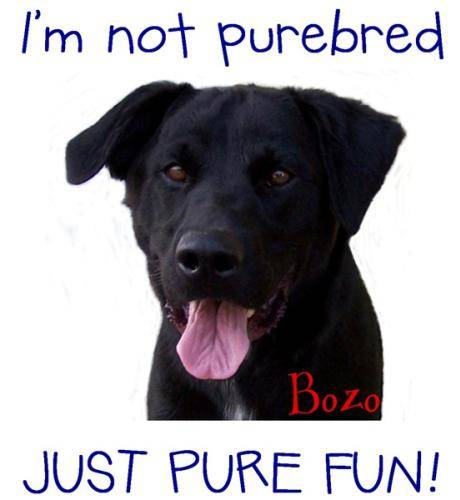

In [15]:
pil_img = Image.open(img_path)
pil_img

# torchvision 라이브러리, transforms 모듈의 다양한 클래스
- 다양한 이미지 변환 기능 제공

In [16]:
from torchvision import transforms # 데이터 다양하게 변형

## Compose 클래스
- 여러 단계로 변환해야하는 경우 transform 객체들을 묶어서 순차적으로 처리
- 학습용, 검증용 > 2가지 만들어야함
- 데이터셋 전 미리 만듬

In [17]:
lst = [
    transforms.RandomHorizontalFlip(p=0.5), # 데이터 증강
    transforms.RandomVerticalFlip(p=0.5), # 데이터 증강
    # transforms.RandomApply(transforms.RandomAffine(45, scale = [0.8, 1.2]), p=0.5) # Apply 적용
    # transforms.RandomAffine(45, scale = [0.8, 1.2]) # 데이터 증강
    transforms.Resize([150,150]),
    transforms.ToTensor() # MinMax+permute+Tensor 동시적용

]

train_trans = transforms.Compose(lst)

lst = [

    transforms.Resize([150,150]),
    transforms.ToTensor() # MinMax+permute+Tensor 동시적용

]

test_trans = transforms.Compose(lst)

# 데이터셋 클래스

In [18]:
class CatDogDataset(torch.utils.data.Dataset):
  def __init__(self, trans, x, y):
    self.x = x
    self.y = y
    self.trans = trans

  def __len__(self): # 샘플 수 반환
    return self.x.shape[0]

  def __getitem__(self, idx):
    item = {}
    x= Image.open(self.x[idx]) # pillow 이미지 객체 반환
    item['x'] = self.trans(x) # channel, height, width
    if self.y is not None:
      item['y'] = torch.Tensor(self.y[idx]) # 이진분류문제 >  Tensor > 정답데이터타입 float32

    return item

- 결과 확인하기

In [19]:
dt = CatDogDataset(train_trans, train_path, target)
dt[0]['x'].shape

torch.Size([3, 150, 150])

In [20]:
dl = torch.utils.data.DataLoader(dt, batch_size = 2, shuffle = False)
batch = next(iter(dl))
batch # float32일 때, 데이터타입 표시 x > 정상

{'x': tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
          [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
          [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000,

In [21]:
batch['x'].shape # b, c, h, w

torch.Size([2, 3, 150, 150])

# 신경망 모델클래스 구현

In [22]:
batch['x'].shape[1] # 채널 개수

3

In [23]:
class Net(torch.nn.Module):
  def __init__(self, out_channel= 16, kernel_size= 3):
    super().__init__()
    self.seq = torch.nn.Sequential(
        torch.nn.Conv2d(3, out_channel, kernel_size), # 채널개수=3
        torch.nn.BatchNorm2d(out_channel),
        torch.nn.ELU(),
        torch.nn.MaxPool2d(2),

        torch.nn.Conv2d(out_channel, out_channel * 2, kernel_size),
        torch.nn.BatchNorm2d(out_channel * 2),
        torch.nn.ELU(),
        torch.nn.MaxPool2d(2),

        torch.nn.AdaptiveMaxPool2d(1), # batch, channel, height, width > batch, channel, 1, 1
        torch.nn.Flatten(), # default: 1 > 인덱스번호 1부터 평탄화,   batch, channel * 1 * 1 > batch, channel
        torch.nn.Linear(out_channel * 2, 1) # 이진분류이므로 1
    )

  def forward(self, x):
    return self.seq(x)

- 결과 확인하기

In [24]:
model = Net()
model(batch['x'])

tensor([[-2.8013],
        [-1.1262]], grad_fn=<AddmmBackward0>)

# 학습 loop함수 만들기

In [25]:
def train_loop(dl, model, loss_fn, optimizer, device):
  epoch_loss = 0
  model.train() # 학습모드
  for batch in dl:
    pred = model(batch['x'].to(device))
    loss = loss_fn(pred, batch['y'].to(device))

    optimizer.zero_grad() # 기울기 0 초기화
    loss.backward() # 역전파
    optimizer.step() # 가중치업데이트

    epoch_loss += loss.item()
  epoch_loss /= len(dl)
  return epoch_loss

# 검증 및 테스트 loop함수 만들기

In [26]:
@torch.no_grad() # 경사추적 중단
def test_loop(dl, model, loss_fn, device):
  epoch_loss = 0
  model.eval() # 평가모드

  act = torch.nn.Sigmoid() # 회귀에서 사용 x, 시그모이드: 0~1값으로 전환
  pred_list = []
  for batch in dl:
    pred = model(batch['x'].to(device))
    if batch.get('y') is not None:
      loss = loss_fn(pred, batch['y'].to(device))
      epoch_loss += loss.item()

    pred = act(pred) # 회귀에서 사용 x
    pred = pred.to('cpu').numpy()
    pred_list.append(pred)

  pred = np.concatenate(pred_list)
  epoch_loss /= len(dl)
  return epoch_loss, pred

# 하이퍼파라미터 정의

In [27]:
batch_size = 32
loss_fn = torch.nn.BCEWithLogitsLoss()
epochs = 100
n_splits = 5 #kfold의 k값

# 조합 후 K-fold학습 수행

In [28]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
cv = KFold(n_splits, shuffle = True, random_state = SEED)

In [30]:
is_holdout = False
reset_seeds(SEED)
score_list = []

for i, (tri,vai) in enumerate(cv.split(train_path)):
  model = Net().to(device)
  optimizer = torch.optim.Adam(model.parameters())

  # 학습데이터
  train_dt = CatDogDataset(train_trans, train_path[tri], target[tri])
  train_dl = torch.utils.data.DataLoader(train_dt, batch_size = batch_size, shuffle = True)

  #검증데이터
  valid_dt = CatDogDataset(test_trans, train_path[vai], target[vai])
  valid_dl = torch.utils.data.DataLoader(valid_dt, batch_size = batch_size, shuffle = False)

  best_score = 0
  patience = 0
  for epoch in range(epochs):
    train_loss = train_loop(train_dl, model, loss_fn, optimizer, device)
    valid_loss, pred = test_loop(valid_dl, model, loss_fn, device)
    pred = (pred > 0.5).astype(int)
    score = roc_auc_score(target[vai], pred)

    print(train_loss, valid_loss, score)
    patience += 1

    if score > best_score:
      patience = 0
      best_score = score
      torch.save(model.state_dict(), f'model_{i}.pt') # 가중치만 저장

    if patience == 5:
      break
  print(f'Fold-{i}, Best_ACC : {best_score}')
  score_list.append(best_score)
  if is_holdout:
    break

0.7474902594089508 0.6960614461165208 0.49348370927318297
0.6809570801258087 0.6831247210502625 0.5577694235588972
0.6628064084053039 0.6811986748988812 0.5655388471177946
0.6427256035804748 0.6530050406089196 0.6295739348370928
0.6348100543022156 0.6523352953103873 0.6291979949874686
0.6257034575939179 0.6251614414728605 0.668170426065163
0.6369518768787384 0.6352800405942477 0.6473684210526316
0.6171063470840454 0.6210336685180664 0.7027568922305765
0.6034701883792877 0.6145376287973844 0.6750626566416039
0.5886820465326309 0.5995621727063105 0.7041353383458647
0.5906875336170196 0.5957396855721107 0.6669172932330827
0.5830250245332718 0.6151650777229896 0.6154135338345865
0.577944262623787 0.5837778494908259 0.6958646616541353
0.5607846903800965 0.5782771431482755 0.706390977443609
0.5648669362068176 0.571267538345777 0.6739348370927318
0.571137924194336 0.5633333531709818 0.731704260651629
0.5530482935905456 0.5812931610987737 0.6972431077694236
0.5535664415359497 0.563937480633075

- 평균으로 결과 확인하기

In [31]:
np.mean(score_list)

0.718907401196513

# test데이터 추론하기

In [32]:
cats_test_list = sorted(glob('test/cats/*.jpg')) # 1
dogs_test_list = sorted(glob('test/dogs/*.jpg')) # 0

In [33]:
test_path = np.array(cats_test_list + dogs_test_list)
y_test = np.array(len(cats_test_list) * [0] + len(dogs_test_list) * [1])
y_test

array([0, 0, 0, ..., 1, 1, 1])

In [34]:
test_dt = CatDogDataset(test_trans, test_path, target)
test_dt[0]

{'x': tensor([[[0.5490, 0.5490, 0.5647,  ..., 0.4980, 0.4706, 0.3451],
          [0.5333, 0.5373, 0.5608,  ..., 0.5059, 0.5098, 0.3059],
          [0.4471, 0.4549, 0.4863,  ..., 0.4588, 0.5255, 0.2431],
          ...,
          [0.3333, 0.2824, 0.2431,  ..., 0.3569, 0.3529, 0.3569],
          [0.2863, 0.2471, 0.2275,  ..., 0.4275, 0.4000, 0.3804],
          [0.2588, 0.2314, 0.2235,  ..., 0.4275, 0.3725, 0.3529]],
 
         [[0.4392, 0.4392, 0.4549,  ..., 0.3020, 0.3020, 0.1922],
          [0.4235, 0.4275, 0.4510,  ..., 0.3098, 0.3412, 0.1529],
          [0.3451, 0.3529, 0.3843,  ..., 0.2627, 0.3490, 0.0824],
          ...,
          [0.3059, 0.2549, 0.2118,  ..., 0.3137, 0.3059, 0.3098],
          [0.2588, 0.2196, 0.1961,  ..., 0.3843, 0.3529, 0.3333],
          [0.2314, 0.2039, 0.1922,  ..., 0.3843, 0.3255, 0.3059]],
 
         [[0.2941, 0.2941, 0.3098,  ..., 0.2118, 0.2275, 0.1255],
          [0.2784, 0.2824, 0.3059,  ..., 0.2196, 0.2667, 0.0863],
          [0.2078, 0.2157, 0.2471, 

In [35]:
test_dl = torch.utils.data.DataLoader(test_dt, batch_size = batch_size, shuffle = False)

In [36]:
pred_list = []
for i in range(n_splits):
  model = Net().to(device)
  state_dict = torch.load(f'model_{i}.pt', weights_only=True)
  model.load_state_dict(state_dict)

  _, pred = test_loop(test_dl, model, loss_fn, device)
  pred_list.append(pred)

In [37]:
pred = np.mean(pred_list, axis = 0)
pred = (pred>0.5).astype(int)
pred.shape

(2000, 1)

In [38]:
from sklearn.metrics import accuracy_score

In [39]:
accuracy_score(y_test, pred)

0.7375